# Språkmodeller

*Nøkkelbegreper:* enkle språkmodeller, betinget sannsynlighet, estimering av sannsynligheter, treningsdata

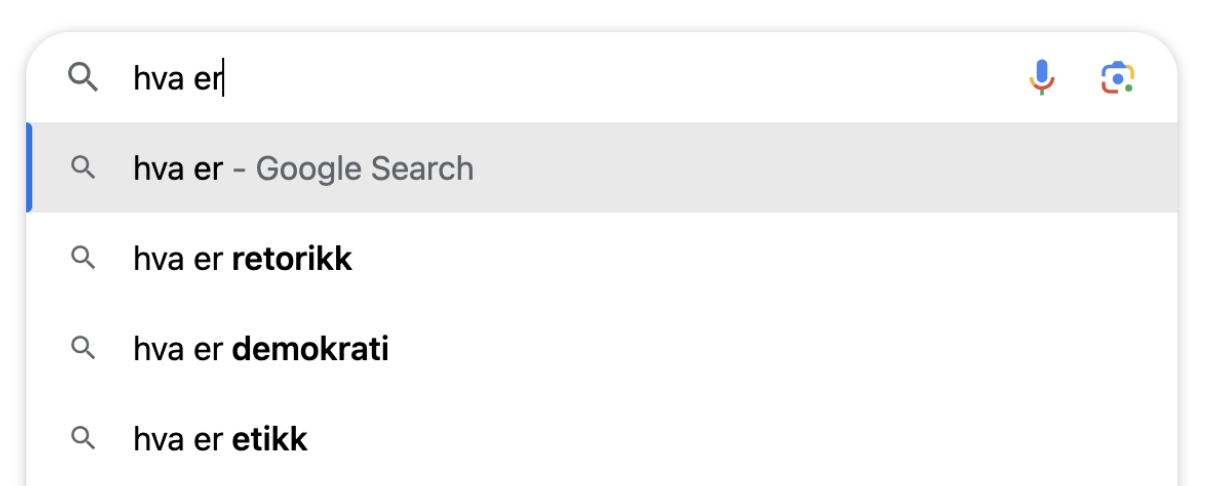

Figuren viser skjermdump av et Google-søk (28. august 2023). Hvorfor tror Google at jeg lurer på hva retorikk er? Og hvorfor er demokrati og etikk på andre- og tredjeplass i denne lista av forslag? I denne notatboken kan du lese om enkle språkmodeller. Viktige temaer er betinget sannsynlighet og utvalg/treningsdata.

## Hva er en språkmodell?

Store språkmodeller (large language models, LMMs) har blitt svært aktuelle siden 2022 gjennom f.eks ChatGTP, my AI, Bard og Bing. Men hva er egentlig en språkmodell? Og hva har det med sannsynlighetsteori å gjøre?

La $w_1$, $w_2$, ... $w_n$ være en rekke av $n$ ord. En språkmodell tilegner en sannsynlighet $P(w_1, w_2, \ldots, w_n)$ til denne rekken av ord basert på treningsdata. 

La oss for eksempel tenke oss en språkmodell som er utviklet ("trent") basert på lærebøker i statistikk. Rekken "gjennomsnittet av observasjonene" vil da (mest sannsynlig) tilegnes en større sannsynlighet enn "kampen starter klokka åtte". 

### Neste ord i rekka og betinget sannsynlighet

Enkle språkmodeller kan for brukes for å gjette neste ord i en setning, som illustrert med Google-søket over. For å gi brukeren gode svar eller gjetninger (prediksjoner) bruker modellen betingede sannsynligheter. Gitt en *prompt* (en rekke av ord eller et spørsmål), hva er det mest sannsynlige neste ordet eller den mest sannsynlige setningen? Slike betingede sannsynligheter "lærer" språkmodeller fra treningsdata. 

Antageligvis har mange Google-brukere som ligner på meg søkt på nettopp retorikk, demokrato og etikk den siste tiden. Fra disse treningsdataene gjetter modellen på at "hva er" mest sannsynlig vil etterfølges av et av disse temaene. *Hvilke forslag får du?*

### N-gram språkmodeller

En av de enkleste språkmodellene vi kan trene på et datasett (gjerne kalt et *korpus* av tekst) er en bigram-modell. I en bigram-modell vil neste ord predikeres kun basert det forrige ordet. I en trigram-modell vil det neste ordet predikeres basert på de *to* foregående ordene. Generelt er N-gram språkmodeller basert på antagelsen om at  neste ord i en setning kan predikeres ut i fra de N-1 foregående ordene i setningen (for bigram-modeller er N = 2 og N-1 = 1, for trigram-modeller er N = 3 og N-1 = 2). For Google-søket over kan vi tenke oss en trigram-modell der 
$P(\text{retorikk } | \text{ hva er}) > P(\text{demokrati } | \text{ hva er}) > P(\text{etikk } | \text{ hva er}).$


#### Eksempel 1: Bigram modell

I dette eksempelet skal vi selv "trene" en bigram-modell basert på følgende tekst: 

*ty ta te to te tu te ti ta tu ta tu ta to te to ta ty ti ty*

Teksten består av en rekke med seks unike (og fiktive) ord: ta, te, ti, to, ty, tu. Å trene modellen betyr rett å slett å regne ut hvor ofte kombinasjoner av ord opptrer i den teksten vi har tilgjengelig. Hvis vi for eksempel ser på ordet "te" så opptrer det fire ganger i teksten. I to av disse tilfellene blir "te" etterfulgt av "to". Dermed vil modellen gi oss 
$P(\text{to } | \text{ te}) = \frac{2}{4} = 0.5$.
Med andre ord, modellen har estimert at sjansen at for ordet "to" kommer etter ordet "te" er 0.5. På samme måte er 
$P(\text{tu } | \text{ te}) = \frac{1}{4} = 0.25$ og $P(\text{ti } | \text{ te}) = \frac{1}{4} = 0.25$, mens 
$P(\text{ty } | \text{ te}) = 0$ fordi kombinasjonen "te ty" aldri opptrer i treningsdataene. 

#### Eksempel 2: Trigram modell

I dette eksempelet skal vi se for oss at en trigram (3-gram) språkmodell har blitt trent på samtaler mellom studenter. Gitt ordene "han gikk til", hva er mulige utfall for neste ord i setningen? Og hvilket er det mest sannsynlige av disse? Først og fremst kan vi stryke det første ordet "han" siden en trigram-modell kun tar hensyn til de to siste ordene ("gikk" og "til"). Modellen gir oss:

mulige utfall etter "gikk til" = {kantina, forelesning, lesesalen}, der

- $P(\text{kantina } | \text{ gikk til}) = 0.60$
- $P(\text{forelesning } | \text{ gikk til}) = 0.25$
- $P(\text{lesesalen } | \text{ gikk til}) = 0.15$

Merk at enkle N-gram modeller bare kan gi oss sannsynligheter for rekker av ord som faktisk finnes i treningsdataene. Mer avanserte språkmodeller har ikke denne begrensningen.

## Tilpass en trigram (3-gram) språkmodell i Python

Vi skal nå bruke Python til å trene en trigram språkmodell. Vi skal få maskinen vår til å "lese gjennom" en mengde avisartikler og beregne sannsynligheter for neste ord gitt to foregående ord. Vi skal også bruke modellen til å generere nye setninger.

For å gjøre dette bruker vi pakken "nltk", som blant annet inneholder ulike korpus (datasett med tekst) for nedlastning (se https://www.nltk.org/nltk_data/). Vi skal her bruke "Reuters-21578  benchmark corpus" som består av 10788 nyhetsartikler. Vi skal også bruke en del funksjoner som er spesielt laget for for håndtering av ord og setninger. Koden er hentet fra https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d, som videre referer til https://nlpforhackers.io/language-models/.

In [ ]:
# Vi starter med å importere nødvendige pakker og laster ned nødvendige datasett
import nltk
nltk.download('reuters')
nltk.download('punkt') 
from nltk.corpus import reuters
from collections import defaultdict
import random

#### Treningsdata
Vi gjør oss først litt kjent med treningsdataene (tekst-korpuset) som består av engelske nyhetsartikler.

In [ ]:
reuters.words() # skrive ut de første ordene i reuters-korpuset
#reuters.sents() # skrive ut de første setningene

#### Nyttige funksjoner
Det er greit å vite at nltk-pakken har en egen funksjon som henter ut tre-og-tre ord fra en rekke med ord

In [ ]:
# nltk-pakken har en egen trigrams-funksjon:
list(nltk.trigrams(["han", "går", "til", "kantina"])) # skriver ut en liste av alle tre-og-tre ord

#### Trene modellen (beregne betingede sannsynligheter)
Vi skal nå "lese gjennom" hver setning i datasettet, se på hver unike trio av ord ($w_1, w_2, w_3$), og telle opp hvor ofte det tredje ordet ($w_3$) etterfølger de to foregående ordene ($w_1, w_2$).

In [ ]:
model = defaultdict(lambda: defaultdict(lambda: 0)) # initialisere en tom "ordbok" der nye elementer først tilegnes verdien 0

# Først teller vi opp hvor ofte et ord (w3) kommer etter et par av ord (w1,w2)
for sentence in reuters.sents():
    for w1, w2, w3 in nltk.trigrams(sentence, pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1

In [ ]:
# Nå gjør vi om tellingene våre til frekvenser (estimerte betingede sannsynligheter)
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

#### Resultater
Vi har nå laget en modell som gir oss en oversikt hvilke ord som *kan* etterfølge en rekke på to ord, samt frekvensen av dette (estimert betinget sannsynlighet). 

Vi kan for eksempel se på de to ordene "she was". Hvilke ord kan (basert på treningsdataene) etterfølge disse?

In [ ]:
dict(model["she", "was"])

Vi ser at det er ganske få mulige utfall gitt "she was", og blant disse er "concerned" er det mest sannsynlige neste ordet. Hva hvis vi endrer til "he was"?

In [ ]:
#dict(model["he", "was"]) # tips: bruk funksjonen len() for å telle opp antall mulige utfall!

#### Diskusjon av treningsdataene

Trigram-modellen vår ble trent på avisartikler fra det internasjonale nyhetsbyrået Reuters. Modellen vår vil dermed være god til å fange opp språklige trender i slike nyhetsartikler, men er ikke nødvendigvis overførbar til andre domener. Utvalget vi har brukt er ikke representativt for andre typer tekst eller tale.  

Husk også at språk-modellen vår "bare" er en matematisk utregning av frekvenser av ord i et tekst-korpus. Så hvorfor ser det ut til at den er mer opptatt av menn enn kvinner? Jo, fordi treningsdataene er det. Språkmodeller som er trent på store mengder tilgjengelige tekstmateriale vil ofte avsløre slike skjevheter i treningsdataene med tanke på f.eks. kjønn, etnisitet og religion.

### Generere setninger fra en trigram-modell

Fra trigram-modellen vår kan vi konstruere setninger basert på en input (prompt) bestående av de to første ordene i setningen. Hvis vi for eksempel velger å starte setningen med "she was" må modellen velge et av ordene i utfallsrommet {concerned, looking, not}. Vi kan bestemme at modellen skal velge det mest sannsynlige, eller vi kan trekke fra den estimerte sannsynlighetsfordelingen ${0.5, 0.25, 0.25}$ for de tre ordene i utfallsrommet. Vi starter med å velge det mest sannsynlige ordet ("concerned"), hva blir neste ord?

In [ ]:
dict(model["was", "concerned"])

Ikke overraskende er de mest sannsynlige neste ordene "about", "that" og "the". Merk at nå husker ikke trigram-modellen lenger at vi snakker om en kvinne fordi modellen bare ser to ord bakover i setningen. Forslagene som dukker opp er derfor også basert på setninger i korpuset som omhandler alle mennesker.

Vi kan skrive kode som legger til det mest sannsynlige neste ordet (basert på de to foregående) helt til setningen har en ønsket lenge, eller helt til modellen har valgt punktum som det mest sannsynlige. Den følgende koden er redigert med hjelp av ChatGPT. 

In [ ]:
sentence = ["she", "was"]
max_length = 15
    
while len(sentence) < max_length:
    next_word_probs = model[tuple(sentence[-2:])]
    next_word = max(next_word_probs, key=next_word_probs.get)
        
    if next_word is None:
        break
        
    sentence.append(next_word)
        
print(sentence)

Vi kan prøve oss frem med ulike start-ord så lenge paret av ord eksisterer i tekst-korpuset, f.eks "what if" eller "it could". Hvis du gjør dette ser du at vi får noen ganske gode setninger og noen som blir litt rare. 

Dersom vi ikke velger det mest sannsynlige neste ordet, men i stedet for trekker fra fordelingen av sannsynlige ord får vi flere ulike setninger fra samme input:

In [ ]:
sentence = ["she", "was"]
max_length = 15
    
while len(sentence) < max_length:
    next_word_probs = model[tuple(sentence[-2:])]
    next_words = list(next_word_probs.keys())
    probabilities = list(next_word_probs.values())
    sampled_word = random.choices(next_words, probabilities)[0]
    
    if sampled_word is None:
        break
        
    sentence.append(sampled_word)
        
print(sentence)

Dersom du kjører over koden om og om igjen får du forskjellige forslag til setninger, noen gode og noen ikke så gode. Vi ville antageligvis fått mer realistiske setninger ved utvide modellen til å huske *tre* ord bakover (en 4-gram språkmodell), eller enda fler. Men jo større hukommelse modellen skal ha, jo mer regnekraft bruker vi og jo mer treningsdata bør vi ha. 

## Store språkmodeller

En klar svakhet med modellen vår er at den bare kan gi sannsynligheter til kombinasjoner av tre ord som faktisk opptrer i treningsdataene. Modellen vår kan brukes til å generere nye setninger, men vi ser at setningene blir litt rare. Mer avanserte store språkmodeller er i stand til å kombinere ord som ikke opptrer samtidig i treningsdatane, men som likevel gjør at setningene som genereres fremstår riktige. Slike store maskinlæringsmodeller har en mer kompleks struktur (nevrale nettverk) og er trent på enorme mengder tilgjengelig tekst. Chatboter slik som ChatGPT er bygd opp basert på sore språkmodeller (f.eks GPT-3.5 eller GPT-4) og utviklet til å fungere godt på flere områder; samtaler, spørsmål-og-svar, sammendrag, koding, osv. Til tross for den enorme kompleksiteten ser vi likevel at slike modeller også preges av skjevheter i treningsdataene, for eksempel når det kommer til kjønn, etnisitet og alder. 

## Referanser

Rizvi, Mohd Sanad Zaki: A Comprehensive Guide to Build your own Language Model in Python! på medium.com. Hentet 26. juni 2023 fra https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d

Natural language processing for hackers https://nlpforhackers.io/language-models/ Hentet 28. juni 2023

Wold, Sondre: språkmodell i Store norske leksikon på snl.no. Hentet 28. juni 2023 fra https://snl.no/spr%C3%A5kmodell
